In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
import pickle #to download MLP vectors

#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import preprocessing_Origins,\
time_series_henColumn_tsRow,is_day,vertical_travel_distance, li_missingZone_mvtPerc_DU, li_event_chaoticmvt_z_d,\
ZoneVariable, HenDailyVariable_Origins, heatmap_duration_perzone_perhen, TimeSeriesPlot_1row1day,\
nbr_transition, max_duration_zones, openDevice, chi2_distance, sampen
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Define parameters

In [4]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
dico_matching = config.dico_matching
path_var_ver = os.path.join(path_extracted_data,'Variables_Verifications')
#create a director if not existing
if not os.path.exists(path_var_ver):
    os.makedirs(path_var_ver)
print(id_run)

change the configuration file if not done yet!
ALLDATA_


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Download data

In [5]:
#cleaned mvt data
df_init = pd.read_csv(os.path.join(path_extracted_data, id_run+'_CLEANEDDATA.csv'), sep=';', parse_dates=['Timestamp', 'date']) 
print(df_init.shape)
df_init.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(2695668, 16)


,HenID,PenID,system,Zone,model_prediction,Timestamp,date,next_record_date,duration,previous_record_date,previous_duration,next_zone,previous_zone,previous_previous_zone,correction_is_consecutive_equal_initial_zone,is_WG_open
0,hen_71,pen12,10 - 12,3_Zone,1.0,2020-09-29 09:07:00,2020-09-29,2020-09-29 09:08:26,0 days 00:01:26,NaN,NaN,3_Zone,NaN,NaN,False,False
1,hen_7,pen11,10 - 12,3_Zone,1.0,2020-09-29 09:08:12,2020-09-29,2020-09-29 09:12:16,0 days 00:04:04,NaN,NaN,3_Zone,NaN,NaN,False,False
2,hen_10,pen11,10 - 12,3_Zone,1.0,2020-09-29 09:19:19,2020-09-29,2020-09-29 09:20:27,0 days 00:01:08,NaN,NaN,3_Zone,NaN,NaN,False,False


In [6]:
#daily var
df_daily = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables_verified.csv'), sep=';',
                 parse_dates=['level'],
                 dayfirst=True) 
print(df_daily.shape)
df_daily.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(42300, 63)


,HenID,PenID,CLASS,TagID,FocalLegringName,R-Pen,InitialStartDate,Treatment,level,DIB,...,percChaoticTransition,night_Max_duration_zones,is_mvt_night,empproba_3_Zone,empproba_4_Zone,empproba_2_Zone,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open,SleepingHeight
0,hen_130,pen10,EPI,tag_124,14black,4.0,2020-06-10 00:00:00,TRAN,2020-10-05,6,...,0.0,5_Zone,0.0,0.0,0.0,0.0,NaN,NaN,NaN,3
1,hen_130,pen10,EPI,tag_124,14black,4.0,2020-06-10 00:00:00,TRAN,2020-10-06,7,...,0.0,3_Zone,1.0,100.0,50.0,0.0,NaN,NaN,NaN,1
2,hen_130,pen10,EPI,tag_124,14black,4.0,2020-06-10 00:00:00,TRAN,2020-10-07,8,...,0.0,5_Zone,0.0,50.0,100.0,100.0,NaN,NaN,NaN,3


# Individual Mvt over several days

In [7]:
'''visualise mvt of single animals over several days'''
START_TIME = time.perf_counter()
#choose specific dates to plot, November is better as hens starts to move more and the algo have never seen it
dmin = dt.datetime(2021,5,10)
dmax = dt.datetime(2021,5,15)
df_ = df_init[(df_init['date']<=dmax)&(df_init['date']>=dmin)].copy()
print(df_.shape)
#only print the hens with at least one transition per day (simplicity and interestignly)
#to sort the yaxis
dico_zone_order = {'1_Zone':0, '2_Zone':1, '3_Zone':2, '4_Zone':3, '5_Zone':4}
li_date = df_['date'].unique()
for henID, df_plt in tqdm.tqdm(df_.groupby(['HenID'])):
    df_plt = df_plt.sort_values(['Timestamp']).copy()
    c = 1 ; l = len(li_date)
    fig, ax = plt.subplots(figsize=(c*5, l*1))
    i = 1
    if len(df_plt['date'].unique())==len(li_date):
        mi = min(df_plt['Timestamp'].tolist()) ; ma = max(df_plt['Timestamp'].tolist())
        Daterange = pd.date_range(start = mi+dt.timedelta(seconds=(60-mi.second)), 
                                  end = ma-dt.timedelta(seconds=(ma.second+1)), 
                                  freq = 'S') 
        df_plt_ = df_plt.copy()
        df_plt_.set_index('Timestamp', inplace=True)
        df_plt_ = df_plt_.reindex(Daterange, method='ffill').reset_index()
        df_plt_.rename(columns={'index':'Timestamp'}, inplace=True)
        #add date again, as the reindexing also extended the date
        df_plt_['date'] = df_plt_['Timestamp'].map(lambda x: dt.datetime.date(x))
        #remove first & last date
        df_plt_ = df_plt_[~df_plt_['date'].isin([max(df_plt_['date'].tolist()),min(df_plt_['date'].tolist())])]
        #put xlabel into numbers for the ploting
        df_plt_['Zone'] = df_plt_['Zone'].map(lambda x: int(dico_zone_order[x]))       
        for d, df_plt__ in df_plt_.groupby(['date']):
            df_plt___ = df_plt__.copy()
            plt.subplot(l,c,i)
            plt.tight_layout(pad=0.3) #add spacing between each plot
            plt.yticks([0,1,2,3,4], ['Winter garden', 'Litter', 'Lower perch','Nestbox','Top floor'])
            plt.title(str(d).split('T')[0], size=8)
            i = i+1
            plt.plot(df_plt___['Timestamp'].tolist(), df_plt___['Zone'].tolist(), linewidth=1)
            li_hour = pd.date_range(start = d,  end = d+dt.timedelta(days=1), freq = 'H')
            plt.xticks(li_hour , [str(i.hour)+'h' for i in li_hour], fontsize=5)                
            plt.yticks(fontsize=8)
            plt.ylim(0, 4.2)  
        plt.savefig(os.path.join(path_var_ver,
                                 henID+'_'+str(dmin).split(' ')[0]+'_'+str(dmax).split(' ')[0]+'.png'), 
                    format='png', bbox_inches='tight', dpi=300)
    plt.clf()
    plt.close("all")    
END_TIME = time.perf_counter()
print ("Total running time: %.2f mn" %((END_TIME-START_TIME)/60))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|                                                                                          | 0/158 [00:00<?, ?it/s]

(58479, 16)


100%|████████████████████████████████████████████████████████████████████████████████| 158/158 [26:47<00:00, 10.17s/it]

Total running time: 26.79 mn


# Overall check visual

In [8]:
#print(list(df_daily.columns))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
li_mvt_2verify = [['Total_number_zone','perc_duration_2_Zone','perc_duration_3_Zone','perc_duration_4_Zone','perc_duration_5_Zone'],
        ['vertical_travel_distance','percChaoticTransition','nbr_stays_1_Zone', 'nbr_stays_2_Zone','nbr_stays_3_Zone','nbr_stays_4_Zone','nbr_stays_5_Zone'],
        ['ratio_percdur_percstays_2_Zone', 'ratio_percdur_percstays_3_Zone', 'ratio_percdur_percstays_4_Zone', 'ratio_percdur_percstays_5_Zone'],
        ['latency_2_Zone_h','latency_3_Zone_h','latency_4_Zone_h','latency_5_Zone_h','latency_since15mnnestbox_h'],
        ['distribution_entropy','Max_duration_zones','night_Max_duration_zones','is_mvt_night'],
        ['activity_5percentile_h','activity_50percentile_h','activity_95percentile_h',
         'empproba_2_Zone','empproba_3_Zone','empproba_4_Zone'],
        ['in_WG_15mnAfterOpening', 'Max_duration_WG_h', 'perc_1_Zone_while_WG_open']]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
max_entropy = math.log(5, 2)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(array([ 1747.,   336.,   630.,  1106.,  1810.,  5069.,  8382., 13317.,
         8537.,  1366.]),
 array([0.        , 0.22857152, 0.45714304, 0.68571455, 0.91428607,
        1.14285759, 1.37142911, 1.60000062, 1.82857214, 2.05714366,
        2.28571518]),
 <BarContainer object of 10 artists>)

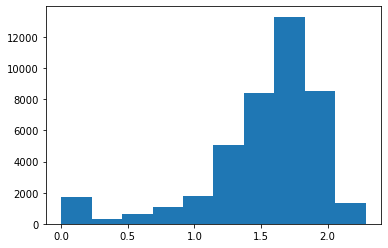

In [11]:
plt.hist(df_daily['distribution_entropy'])

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

(23521, 16)
------------------------------------------------------------------------- hen_10


,Total_number_zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone
5560,5.0,65.0,27.0,6.0,1.0


,vertical_travel_distance,percChaoticTransition,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
5560,74.0,10.0,1.0,31.0,31.0,3.0,3.0


,ratio_percdur_percstays_2_Zone,ratio_percdur_percstays_3_Zone,ratio_percdur_percstays_4_Zone,ratio_percdur_percstays_5_Zone
5560,1.446774,0.600968,1.38,0.23


,latency_2_Zone_h,latency_3_Zone_h,latency_4_Zone_h,latency_5_Zone_h,latency_since15mnnestbox_h
5560,14.891111,15.0,13.773889,13.683611,13.579722


,distribution_entropy,Max_duration_zones,night_Max_duration_zones,is_mvt_night
5560,1.231039,2_Zone,3_Zone,0.0


,activity_5percentile_h,activity_50percentile_h,activity_95percentile_h,empproba_2_Zone,empproba_3_Zone,empproba_4_Zone
5560,2.981389,9.894722,16.462222,96.774194,11.764706,42.857143


,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open
5560,False,0.0325,0.5


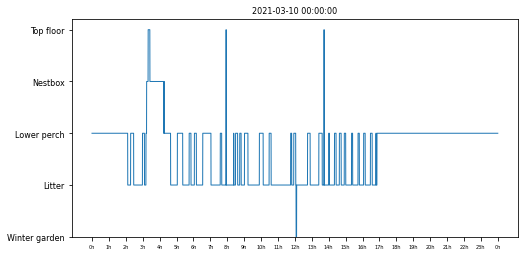

  1%|▌                                                                                 | 1/159 [00:02<06:19,  2.40s/it]

------------------------------------------------------------------------- hen_101


,Total_number_zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone
26526,5.0,43.0,26.0,4.0,25.0


,vertical_travel_distance,percChaoticTransition,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
26526,88.0,25.0,5.0,46.0,42.0,2.0,2.0


,ratio_percdur_percstays_2_Zone,ratio_percdur_percstays_3_Zone,ratio_percdur_percstays_4_Zone,ratio_percdur_percstays_5_Zone
26526,0.906739,0.600476,1.94,12.125


,latency_2_Zone_h,latency_3_Zone_h,latency_4_Zone_h,latency_5_Zone_h,latency_since15mnnestbox_h
26526,10.674722,10.685556,13.396667,15.0,13.396667


,distribution_entropy,Max_duration_zones,night_Max_duration_zones,is_mvt_night
26526,1.818527,5_Zone,2_Zone,1.0


,activity_5percentile_h,activity_50percentile_h,activity_95percentile_h,empproba_2_Zone,empproba_3_Zone,empproba_4_Zone
26526,6.473889,13.701944,16.745556,89.130435,2.380952,33.333333


,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open
26526,False,0.120278,4.512821


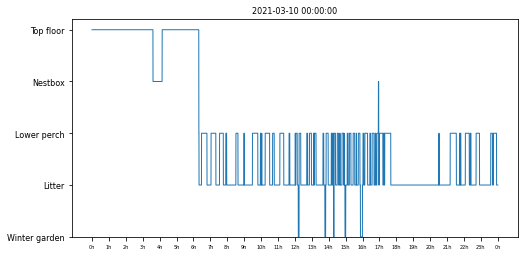

  1%|█                                                                                 | 2/159 [00:04<06:15,  2.39s/it]

------------------------------------------------------------------------- hen_102


,Total_number_zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone
16064,5.0,8.0,2.0,13.0,69.0


,vertical_travel_distance,percChaoticTransition,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
16064,36.0,7.0,10.0,14.0,11.0,13.0,8.0


,ratio_percdur_percstays_2_Zone,ratio_percdur_percstays_3_Zone,ratio_percdur_percstays_4_Zone,ratio_percdur_percstays_5_Zone
16064,0.32,0.101818,0.56,4.83


,latency_2_Zone_h,latency_3_Zone_h,latency_4_Zone_h,latency_5_Zone_h,latency_since15mnnestbox_h
16064,6.704167,14.458889,14.462778,15.0,13.19


,distribution_entropy,Max_duration_zones,night_Max_duration_zones,is_mvt_night
16064,1.452729,5_Zone,5_Zone,0.0


,activity_5percentile_h,activity_50percentile_h,activity_95percentile_h,empproba_2_Zone,empproba_3_Zone,empproba_4_Zone
16064,2.578611,13.719167,16.313889,33.333333,54.545455,53.846154


,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open
16064,False,0.288889,17.482906


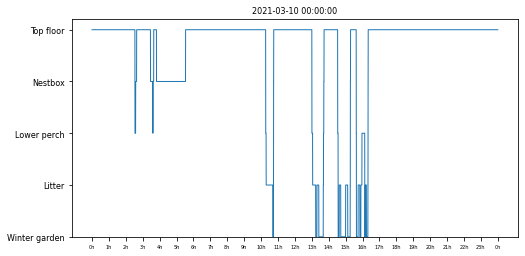

  2%|█▌                                                                                | 3/159 [00:07<06:14,  2.40s/it]

------------------------------------------------------------------------- hen_105


,Total_number_zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone
37156,5.0,50.0,31.0,7.0,8.0


,vertical_travel_distance,percChaoticTransition,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
37156,82.0,23.0,12.0,42.0,35.0,10.0,4.0


,ratio_percdur_percstays_2_Zone,ratio_percdur_percstays_3_Zone,ratio_percdur_percstays_4_Zone,ratio_percdur_percstays_5_Zone
37156,1.22619,0.912286,0.721,2.06


,latency_2_Zone_h,latency_3_Zone_h,latency_4_Zone_h,latency_5_Zone_h,latency_since15mnnestbox_h
37156,14.889722,14.689722,12.982222,15.0,12.982222


,distribution_entropy,Max_duration_zones,night_Max_duration_zones,is_mvt_night
37156,1.790889,4_Zone,5_Zone,0.0


,activity_5percentile_h,activity_50percentile_h,activity_95percentile_h,empproba_2_Zone,empproba_3_Zone,empproba_4_Zone
37156,3.766111,12.879167,16.529167,71.428571,21.052632,27.272727


,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open
37156,False,0.135833,9.564103


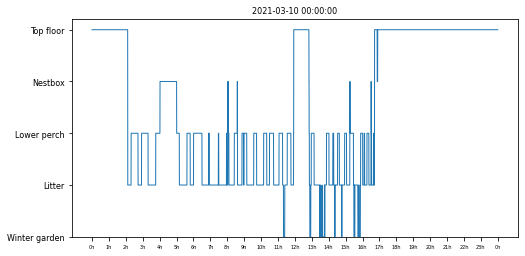

  3%|██                                                                                | 4/159 [00:09<06:16,  2.43s/it]

------------------------------------------------------------------------- hen_106


,Total_number_zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone
37328,5.0,27.0,14.0,12.0,45.0


,vertical_travel_distance,percChaoticTransition,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
37328,62.0,32.0,1.0,23.0,27.0,10.0,3.0


,ratio_percdur_percstays_2_Zone,ratio_percdur_percstays_3_Zone,ratio_percdur_percstays_4_Zone,ratio_percdur_percstays_5_Zone
37328,0.751304,0.331852,0.768,9.6


,latency_2_Zone_h,latency_3_Zone_h,latency_4_Zone_h,latency_5_Zone_h,latency_since15mnnestbox_h
37328,10.276944,10.856389,15.0,14.868333,12.313611


,distribution_entropy,Max_duration_zones,night_Max_duration_zones,is_mvt_night
37328,1.853494,5_Zone,4_Zone,1.0


,activity_5percentile_h,activity_50percentile_h,activity_95percentile_h,empproba_2_Zone,empproba_3_Zone,empproba_4_Zone
37328,6.723056,14.630278,16.795278,95.454545,21.428571,30.0


,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open
37328,False,0.120556,1.854701


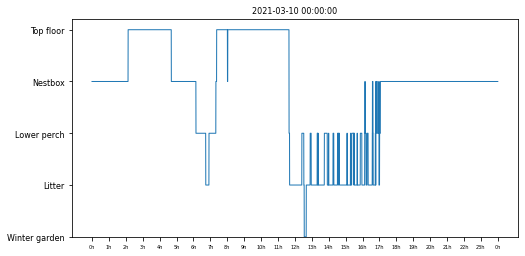

  3%|██▌                                                                               | 5/159 [00:12<06:19,  2.47s/it]

------------------------------------------------------------------------- hen_107


,Total_number_zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone
26793,5.0,52.0,31.0,4.0,11.0


,vertical_travel_distance,percChaoticTransition,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
26793,150.0,17.0,2.0,51.0,62.0,26.0,12.0


,ratio_percdur_percstays_2_Zone,ratio_percdur_percstays_3_Zone,ratio_percdur_percstays_4_Zone,ratio_percdur_percstays_5_Zone
26793,1.56,0.765,0.235385,1.4025


,latency_2_Zone_h,latency_3_Zone_h,latency_4_Zone_h,latency_5_Zone_h,latency_since15mnnestbox_h
26793,14.9,15.0,13.747222,13.74,13.198056


,distribution_entropy,Max_duration_zones,night_Max_duration_zones,is_mvt_night
26793,1.65013,2_Zone,4_Zone,1.0


,activity_5percentile_h,activity_50percentile_h,activity_95percentile_h,empproba_2_Zone,empproba_3_Zone,empproba_4_Zone
26793,2.533889,13.848056,16.623889,96.078431,22.222222,46.153846


,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open
26793,False,0.127778,3.726496


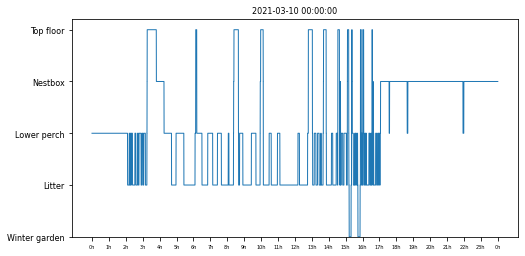

  4%|███                                                                               | 6/159 [00:14<06:17,  2.47s/it]

------------------------------------------------------------------------- hen_108


,Total_number_zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone
5832,5.0,45.0,38.0,11.0,5.0


,vertical_travel_distance,percChaoticTransition,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
5832,104.0,25.0,1.0,30.0,51.0,23.0,2.0


,ratio_percdur_percstays_2_Zone,ratio_percdur_percstays_3_Zone,ratio_percdur_percstays_4_Zone,ratio_percdur_percstays_5_Zone
5832,1.605,0.797255,0.511739,2.675


,latency_2_Zone_h,latency_3_Zone_h,latency_4_Zone_h,latency_5_Zone_h,latency_since15mnnestbox_h
5832,14.8625,15.0,14.646944,10.214444,14.327778


,distribution_entropy,Max_duration_zones,night_Max_duration_zones,is_mvt_night
5832,1.647222,5_Zone,3_Zone,0.0


,activity_5percentile_h,activity_50percentile_h,activity_95percentile_h,empproba_2_Zone,empproba_3_Zone,empproba_4_Zone
5832,2.489722,8.659722,16.260278,96.666667,42.0,8.695652


,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open
5832,False,0.0425,0.653846


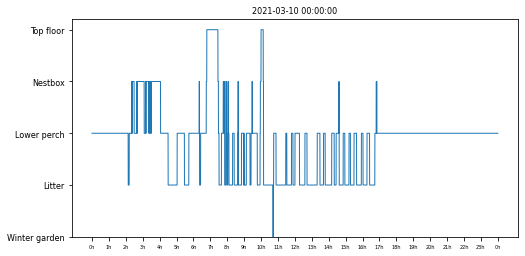

  4%|███▌                                                                              | 7/159 [00:17<06:13,  2.46s/it]

------------------------------------------------------------------------- hen_109


,Total_number_zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone
27060,5.0,36.0,17.0,9.0,37.0


,vertical_travel_distance,percChaoticTransition,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
27060,79.0,8.0,2.0,26.0,31.0,10.0,8.0


,ratio_percdur_percstays_2_Zone,ratio_percdur_percstays_3_Zone,ratio_percdur_percstays_4_Zone,ratio_percdur_percstays_5_Zone
27060,1.066154,0.422258,0.693,3.56125


,latency_2_Zone_h,latency_3_Zone_h,latency_4_Zone_h,latency_5_Zone_h,latency_since15mnnestbox_h
27060,14.801111,15.0,14.003889,14.525278,12.693056


,distribution_entropy,Max_duration_zones,night_Max_duration_zones,is_mvt_night
27060,1.863104,5_Zone,3_Zone,1.0


,activity_5percentile_h,activity_50percentile_h,activity_95percentile_h,empproba_2_Zone,empproba_3_Zone,empproba_4_Zone
27060,2.996111,11.174722,16.425833,92.0,25.0,50.0


,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open
27060,False,0.064167,1.491453


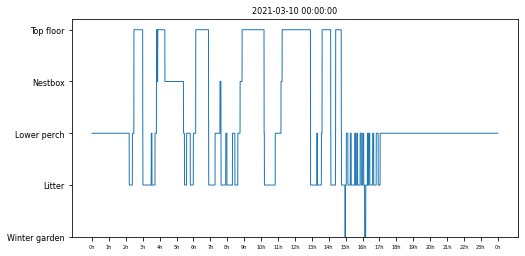

  5%|████▏                                                                             | 8/159 [00:19<06:14,  2.48s/it]

------------------------------------------------------------------------- hen_111


,Total_number_zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone
6007,4.0,49.0,21.0,5.0,25.0


,vertical_travel_distance,percChaoticTransition,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
6007,68.0,3.0,0.0,19.0,23.0,12.0,8.0


,ratio_percdur_percstays_2_Zone,ratio_percdur_percstays_3_Zone,ratio_percdur_percstays_4_Zone,ratio_percdur_percstays_5_Zone
6007,1.598947,0.566087,0.258333,1.9375


,latency_2_Zone_h,latency_3_Zone_h,latency_4_Zone_h,latency_5_Zone_h,latency_since15mnnestbox_h
6007,14.773056,14.777222,14.782222,15.0,12.038889


,distribution_entropy,Max_duration_zones,night_Max_duration_zones,is_mvt_night
6007,1.701137,5_Zone,5_Zone,0.0


,activity_5percentile_h,activity_50percentile_h,activity_95percentile_h,empproba_2_Zone,empproba_3_Zone,empproba_4_Zone
6007,2.4375,9.586389,14.301111,100.0,29.62963,46.666667


,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open
6007,False,0.0,0.0


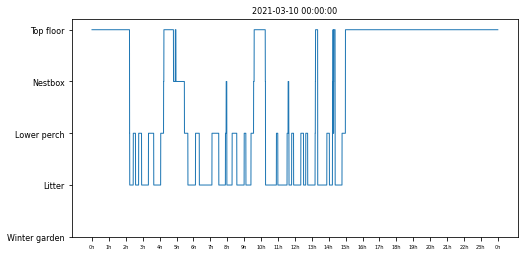

  6%|████▋                                                                             | 9/159 [00:22<06:05,  2.44s/it]

------------------------------------------------------------------------- hen_112


,Total_number_zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone
6181,4.0,41.0,23.0,11.0,25.0


,vertical_travel_distance,percChaoticTransition,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
6181,108.0,16.0,0.0,29.0,48.0,23.0,7.0


,ratio_percdur_percstays_2_Zone,ratio_percdur_percstays_3_Zone,ratio_percdur_percstays_4_Zone,ratio_percdur_percstays_5_Zone
6181,1.512759,0.512708,0.511739,3.821429


,latency_2_Zone_h,latency_3_Zone_h,latency_4_Zone_h,latency_5_Zone_h,latency_since15mnnestbox_h
6181,14.867222,14.879167,13.776944,15.0,13.384722


,distribution_entropy,Max_duration_zones,night_Max_duration_zones,is_mvt_night
6181,1.859226,5_Zone,5_Zone,0.0


,activity_5percentile_h,activity_50percentile_h,activity_95percentile_h,empproba_2_Zone,empproba_3_Zone,empproba_4_Zone
6181,2.888333,13.020556,16.470833,100.0,39.583333,24.0


,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open
6181,False,0.0,0.0


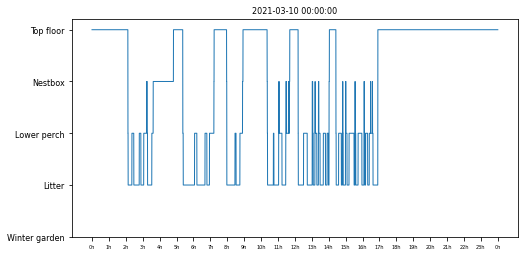

  6%|█████                                                                            | 10/159 [00:24<05:58,  2.41s/it]

------------------------------------------------------------------------- hen_113


,Total_number_zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone
37650,5.0,19.0,21.0,4.0,53.0


,vertical_travel_distance,percChaoticTransition,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
37650,36.0,33.0,11.0,19.0,14.0,10.0,5.0


,ratio_percdur_percstays_2_Zone,ratio_percdur_percstays_3_Zone,ratio_percdur_percstays_4_Zone,ratio_percdur_percstays_5_Zone
37650,0.59,0.885,0.236,6.254


,latency_2_Zone_h,latency_3_Zone_h,latency_4_Zone_h,latency_5_Zone_h,latency_since15mnnestbox_h
37650,12.398889,13.5675,14.030278,15.0,14.030278


,distribution_entropy,Max_duration_zones,night_Max_duration_zones,is_mvt_night
37650,1.768583,5_Zone,5_Zone,0.0


,activity_5percentile_h,activity_50percentile_h,activity_95percentile_h,empproba_2_Zone,empproba_3_Zone,empproba_4_Zone
37650,4.601111,14.325556,16.009167,42.105263,42.857143,40.0


,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open
37650,False,0.094167,8.508547


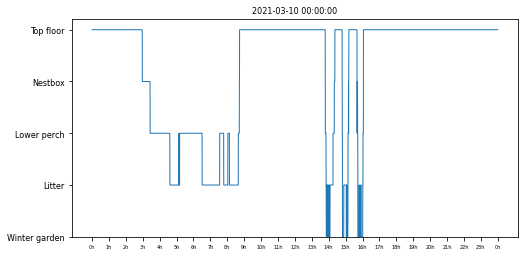

  7%|█████▌                                                                           | 11/159 [00:26<05:49,  2.36s/it]

------------------------------------------------------------------------- hen_115


,Total_number_zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone
16422,5.0,64.0,27.0,7.0,1.0


,vertical_travel_distance,percChaoticTransition,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
16422,79.0,24.0,4.0,42.0,39.0,2.0,1.0


,ratio_percdur_percstays_2_Zone,ratio_percdur_percstays_3_Zone,ratio_percdur_percstays_4_Zone,ratio_percdur_percstays_5_Zone
16422,1.340952,0.609231,3.08,0.88


,latency_2_Zone_h,latency_3_Zone_h,latency_4_Zone_h,latency_5_Zone_h,latency_since15mnnestbox_h
16422,14.881667,14.893889,14.903056,15.0,13.246944


,distribution_entropy,Max_duration_zones,night_Max_duration_zones,is_mvt_night
16422,1.288145,4_Zone,3_Zone,1.0


,activity_5percentile_h,activity_50percentile_h,activity_95percentile_h,empproba_2_Zone,empproba_3_Zone,empproba_4_Zone
16422,2.632222,12.133056,16.698611,90.243902,2.564103,0.0


,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open
16422,True,0.042222,1.786325


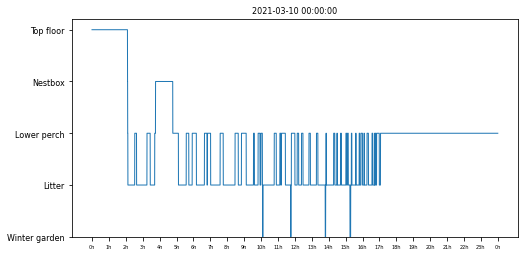

  8%|██████                                                                           | 12/159 [00:29<05:50,  2.38s/it]

------------------------------------------------------------------------- hen_116


,Total_number_zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone
37871,4.0,42.0,15.0,3.0,40.0


,vertical_travel_distance,percChaoticTransition,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
37871,40.0,11.0,0.0,16.0,17.0,2.0,3.0


,ratio_percdur_percstays_2_Zone,ratio_percdur_percstays_3_Zone,ratio_percdur_percstays_4_Zone,ratio_percdur_percstays_5_Zone
37871,0.9975,0.335294,0.57,5.066667


,latency_2_Zone_h,latency_3_Zone_h,latency_4_Zone_h,latency_5_Zone_h,latency_since15mnnestbox_h
37871,12.431667,12.589722,12.999722,15.0,12.999722


,distribution_entropy,Max_duration_zones,night_Max_duration_zones,is_mvt_night
37871,1.613509,5_Zone,5_Zone,0.0


,activity_5percentile_h,activity_50percentile_h,activity_95percentile_h,empproba_2_Zone,empproba_3_Zone,empproba_4_Zone
37871,4.410278,11.356111,15.218333,100.0,11.111111,50.0


,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open
37871,False,0.0,0.0


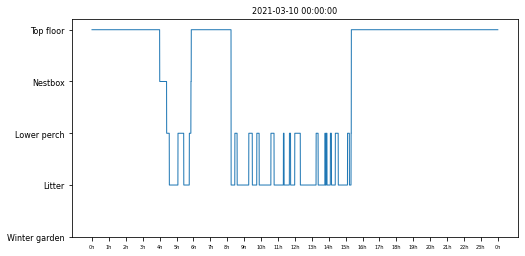

  8%|██████▌                                                                          | 13/159 [00:31<05:46,  2.37s/it]

------------------------------------------------------------------------- hen_118


,Total_number_zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone
6504,4.0,70.0,19.0,4.0,7.0


,vertical_travel_distance,percChaoticTransition,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
6504,126.0,28.0,0.0,53.0,54.0,5.0,6.0


,ratio_percdur_percstays_2_Zone,ratio_percdur_percstays_3_Zone,ratio_percdur_percstays_4_Zone,ratio_percdur_percstays_5_Zone
6504,1.558491,0.415185,0.944,1.376667


,latency_2_Zone_h,latency_3_Zone_h,latency_4_Zone_h,latency_5_Zone_h,latency_since15mnnestbox_h
6504,14.801111,14.678889,11.205278,15.0,10.868333


,distribution_entropy,Max_duration_zones,night_Max_duration_zones,is_mvt_night
6504,1.255997,2_Zone,5_Zone,0.0


,activity_5percentile_h,activity_50percentile_h,activity_95percentile_h,empproba_2_Zone,empproba_3_Zone,empproba_4_Zone
6504,2.793056,10.967778,16.510278,100.0,8.62069,50.0


,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open
6504,False,0.0,0.0


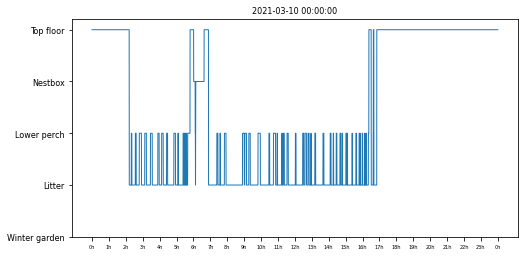

  9%|███████▏                                                                         | 14/159 [00:33<05:44,  2.37s/it]

------------------------------------------------------------------------- hen_119


,Total_number_zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone
27354,5.0,53.0,34.0,10.0,3.0


,vertical_travel_distance,percChaoticTransition,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
27354,62.0,10.0,2.0,30.0,30.0,1.0,1.0


,ratio_percdur_percstays_2_Zone,ratio_percdur_percstays_3_Zone,ratio_percdur_percstays_4_Zone,ratio_percdur_percstays_5_Zone
27354,1.130667,0.725333,6.4,1.92


,latency_2_Zone_h,latency_3_Zone_h,latency_4_Zone_h,latency_5_Zone_h,latency_since15mnnestbox_h
27354,14.828056,15.0,11.6525,8.553611,11.6525


,distribution_entropy,Max_duration_zones,night_Max_duration_zones,is_mvt_night
27354,1.541263,4_Zone,3_Zone,0.0


,activity_5percentile_h,activity_50percentile_h,activity_95percentile_h,empproba_2_Zone,empproba_3_Zone,empproba_4_Zone
27354,2.688611,10.130556,16.228611,93.333333,6.666667,33.333333


,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open
27354,True,0.057778,1.58547


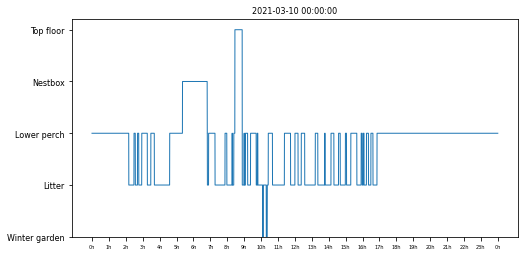

  9%|███████▋                                                                         | 15/159 [00:36<05:42,  2.38s/it]

------------------------------------------------------------------------- hen_120


,Total_number_zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone
38140,5.0,25.0,10.0,10.0,53.0


,vertical_travel_distance,percChaoticTransition,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
38140,90.0,19.0,3.0,18.0,31.0,30.0,14.0


,ratio_percdur_percstays_2_Zone,ratio_percdur_percstays_3_Zone,ratio_percdur_percstays_4_Zone,ratio_percdur_percstays_5_Zone
38140,1.333333,0.309677,0.32,3.634286


,latency_2_Zone_h,latency_3_Zone_h,latency_4_Zone_h,latency_5_Zone_h,latency_since15mnnestbox_h
38140,14.883889,14.904167,15.0,14.5225,13.646667


,distribution_entropy,Max_duration_zones,night_Max_duration_zones,is_mvt_night
38140,1.741994,5_Zone,4_Zone,0.0


,activity_5percentile_h,activity_50percentile_h,activity_95percentile_h,empproba_2_Zone,empproba_3_Zone,empproba_4_Zone
38140,2.4775,13.290833,16.689444,83.333333,51.612903,46.666667


,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open
38140,True,0.123611,3.247863


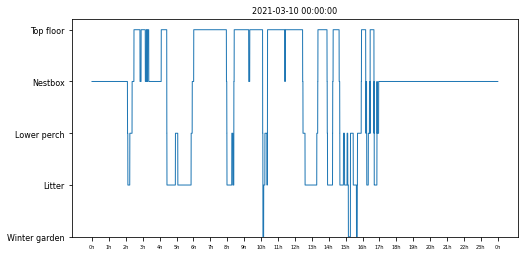

 10%|████████▏                                                                        | 16/159 [00:38<05:37,  2.36s/it]

------------------------------------------------------------------------- hen_122


,Total_number_zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone
10973,5.0,45.0,20.0,6.0,25.0


,vertical_travel_distance,percChaoticTransition,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
10973,154.0,13.0,10.0,54.0,58.0,21.0,17.0


,ratio_percdur_percstays_2_Zone,ratio_percdur_percstays_3_Zone,ratio_percdur_percstays_4_Zone,ratio_percdur_percstays_5_Zone
10973,1.333333,0.551724,0.457143,2.352941


,latency_2_Zone_h,latency_3_Zone_h,latency_4_Zone_h,latency_5_Zone_h,latency_since15mnnestbox_h
10973,14.869444,14.874167,14.877778,15.0,12.468889


,distribution_entropy,Max_duration_zones,night_Max_duration_zones,is_mvt_night
10973,1.917006,2_Zone,5_Zone,0.0


,activity_5percentile_h,activity_50percentile_h,activity_95percentile_h,empproba_2_Zone,empproba_3_Zone,empproba_4_Zone
10973,2.468333,12.557222,16.364722,81.481481,27.868852,48.484848


,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open
10973,True,0.112222,10.247863


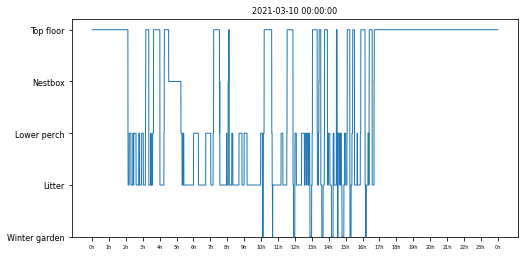

 11%|████████▋                                                                        | 17/159 [00:40<05:36,  2.37s/it]

------------------------------------------------------------------------- hen_124


,Total_number_zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone
31813,5.0,45.0,31.0,3.0,19.0


,vertical_travel_distance,percChaoticTransition,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
31813,48.0,12.0,1.0,16.0,20.0,8.0,4.0


,ratio_percdur_percstays_2_Zone,ratio_percdur_percstays_3_Zone,ratio_percdur_percstays_4_Zone,ratio_percdur_percstays_5_Zone
31813,1.378125,0.7595,0.18375,2.3275


,latency_2_Zone_h,latency_3_Zone_h,latency_4_Zone_h,latency_5_Zone_h,latency_since15mnnestbox_h
31813,12.831389,13.122778,13.592222,15.0,13.592222


,distribution_entropy,Max_duration_zones,night_Max_duration_zones,is_mvt_night
31813,1.728418,5_Zone,5_Zone,0.0


,activity_5percentile_h,activity_50percentile_h,activity_95percentile_h,empproba_2_Zone,empproba_3_Zone,empproba_4_Zone
31813,4.168611,13.368889,16.673889,93.75,28.571429,33.333333


,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open
31813,False,0.140556,2.162393


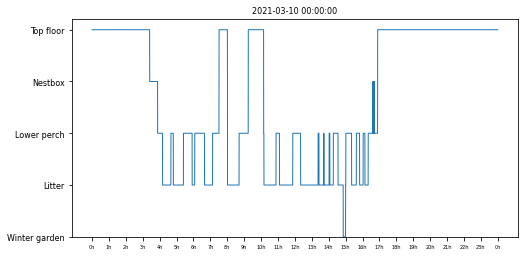

 11%|█████████▏                                                                       | 18/159 [00:43<05:33,  2.37s/it]

------------------------------------------------------------------------- hen_127


,Total_number_zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone
32197,5.0,52.0,24.0,12.0,5.0


,vertical_travel_distance,percChaoticTransition,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
32197,116.0,32.0,16.0,63.0,53.0,8.0,4.0


,ratio_percdur_percstays_2_Zone,ratio_percdur_percstays_3_Zone,ratio_percdur_percstays_4_Zone,ratio_percdur_percstays_5_Zone
32197,1.188571,0.652075,2.16,1.8


,latency_2_Zone_h,latency_3_Zone_h,latency_4_Zone_h,latency_5_Zone_h,latency_since15mnnestbox_h
32197,14.876944,14.730833,11.8775,15.0,11.615


,distribution_entropy,Max_duration_zones,night_Max_duration_zones,is_mvt_night
32197,1.843821,4_Zone,5_Zone,0.0


,activity_5percentile_h,activity_50percentile_h,activity_95percentile_h,empproba_2_Zone,empproba_3_Zone,empproba_4_Zone
32197,2.699167,11.690833,16.724722,74.603175,14.545455,27.272727


,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open
32197,True,0.183889,17.17094


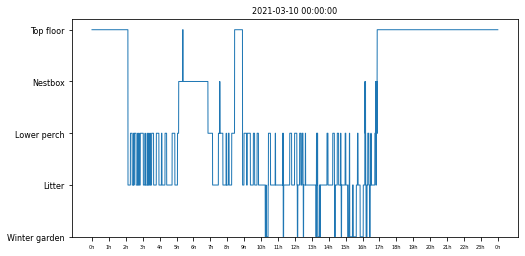

 12%|█████████▋                                                                       | 19/159 [00:45<05:34,  2.39s/it]

------------------------------------------------------------------------- hen_128


,Total_number_zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone
21358,5.0,29.0,48.0,10.0,12.0


,vertical_travel_distance,percChaoticTransition,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
21358,118.0,22.0,1.0,37.0,49.0,16.0,8.0


,ratio_percdur_percstays_2_Zone,ratio_percdur_percstays_3_Zone,ratio_percdur_percstays_4_Zone,ratio_percdur_percstays_5_Zone
21358,0.87,1.087347,0.69375,1.665


,latency_2_Zone_h,latency_3_Zone_h,latency_4_Zone_h,latency_5_Zone_h,latency_since15mnnestbox_h
21358,12.573889,14.14,14.179444,15.0,13.989722


,distribution_entropy,Max_duration_zones,night_Max_duration_zones,is_mvt_night
21358,1.753489,4_Zone,5_Zone,0.0


,activity_5percentile_h,activity_50percentile_h,activity_95percentile_h,empproba_2_Zone,empproba_3_Zone,empproba_4_Zone
21358,4.4225,10.156111,16.6025,97.297297,30.769231,30.434783


,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open
21358,False,0.046111,0.709402


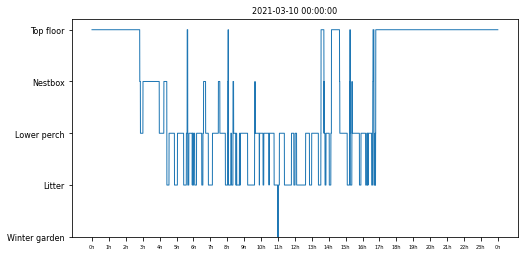

 13%|██████████▏                                                                      | 20/159 [00:48<05:31,  2.39s/it]

------------------------------------------------------------------------- hen_13


,Total_number_zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone
16689,5.0,63.0,30.0,4.0,3.0


,vertical_travel_distance,percChaoticTransition,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
16689,80.0,10.0,1.0,34.0,35.0,5.0,4.0


,ratio_percdur_percstays_2_Zone,ratio_percdur_percstays_3_Zone,ratio_percdur_percstays_4_Zone,ratio_percdur_percstays_5_Zone
16689,1.463824,0.677143,0.632,0.5925


,latency_2_Zone_h,latency_3_Zone_h,latency_4_Zone_h,latency_5_Zone_h,latency_since15mnnestbox_h
16689,14.764167,14.511111,12.653333,15.0,12.590556


,distribution_entropy,Max_duration_zones,night_Max_duration_zones,is_mvt_night
16689,1.317723,2_Zone,5_Zone,0.0


,activity_5percentile_h,activity_50percentile_h,activity_95percentile_h,empproba_2_Zone,empproba_3_Zone,empproba_4_Zone
16689,2.731389,10.68,16.625278,97.058824,10.810811,42.857143


,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open
16689,False,0.062222,0.957265


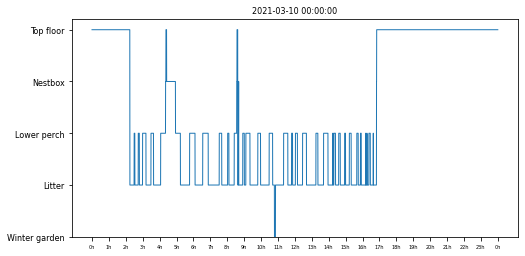

 13%|██████████▋                                                                      | 21/159 [00:50<05:27,  2.37s/it]

------------------------------------------------------------------------- hen_133


,Total_number_zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone
11118,5.0,53.0,25.0,5.0,13.0


,vertical_travel_distance,percChaoticTransition,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
11118,72.0,12.0,7.0,35.0,32.0,4.0,5.0


,ratio_percdur_percstays_2_Zone,ratio_percdur_percstays_3_Zone,ratio_percdur_percstays_4_Zone,ratio_percdur_percstays_5_Zone
11118,1.256857,0.648437,1.0375,2.158


,latency_2_Zone_h,latency_3_Zone_h,latency_4_Zone_h,latency_5_Zone_h,latency_since15mnnestbox_h
11118,14.804444,14.812222,12.530833,15.0,12.285833


,distribution_entropy,Max_duration_zones,night_Max_duration_zones,is_mvt_night
11118,1.776548,5_Zone,5_Zone,0.0


,activity_5percentile_h,activity_50percentile_h,activity_95percentile_h,empproba_2_Zone,empproba_3_Zone,empproba_4_Zone
11118,2.538333,11.874167,16.254722,80.0,12.5,50.0


,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open
11118,True,0.121389,9.32906


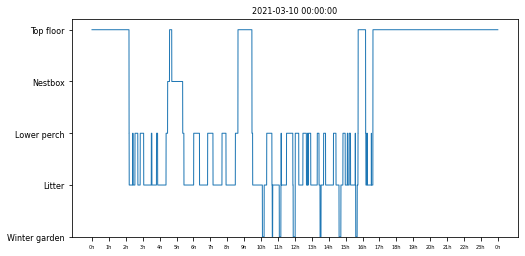

 14%|███████████▏                                                                     | 22/159 [00:52<05:30,  2.41s/it]

------------------------------------------------------------------------- hen_134


,Total_number_zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone
260,5.0,40.0,18.0,13.0,27.0


,vertical_travel_distance,percChaoticTransition,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
260,117.0,19.0,3.0,31.0,51.0,30.0,8.0


,ratio_percdur_percstays_2_Zone,ratio_percdur_percstays_3_Zone,ratio_percdur_percstays_4_Zone,ratio_percdur_percstays_5_Zone
260,1.587097,0.434118,0.533,4.15125


,latency_2_Zone_h,latency_3_Zone_h,latency_4_Zone_h,latency_5_Zone_h,latency_since15mnnestbox_h
260,14.876944,14.903889,15.0,13.327222,12.886944


,distribution_entropy,Max_duration_zones,night_Max_duration_zones,is_mvt_night
260,1.976331,5_Zone,5_Zone,0.0


,activity_5percentile_h,activity_50percentile_h,activity_95percentile_h,empproba_2_Zone,empproba_3_Zone,empproba_4_Zone
260,2.507778,10.770556,16.413056,90.322581,45.098039,25.806452


,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open
260,False,0.128333,4.119658


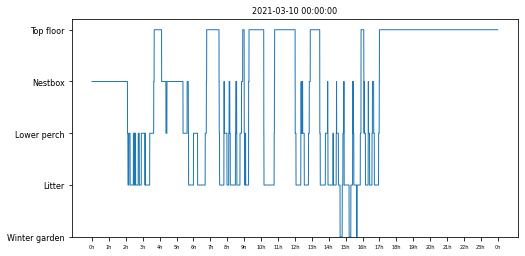

 14%|███████████▋                                                                     | 23/159 [00:55<05:32,  2.45s/it]

------------------------------------------------------------------------- hen_136


,Total_number_zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone
32476,4.0,14.0,9.0,3.0,74.0


,vertical_travel_distance,percChaoticTransition,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
32476,38.0,0.0,0.0,8.0,8.0,10.0,7.0


,ratio_percdur_percstays_2_Zone,ratio_percdur_percstays_3_Zone,ratio_percdur_percstays_4_Zone,ratio_percdur_percstays_5_Zone
32476,0.5775,0.37125,0.099,3.488571


,latency_2_Zone_h,latency_3_Zone_h,latency_4_Zone_h,latency_5_Zone_h,latency_since15mnnestbox_h
32476,12.105278,11.823611,13.324444,15.0,13.324444


,distribution_entropy,Max_duration_zones,night_Max_duration_zones,is_mvt_night
32476,1.185995,5_Zone,3_Zone,1.0


,activity_5percentile_h,activity_50percentile_h,activity_95percentile_h,empproba_2_Zone,empproba_3_Zone,empproba_4_Zone
32476,4.064444,8.523889,16.854722,100.0,38.461538,54.545455


,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open
32476,False,0.0,0.0


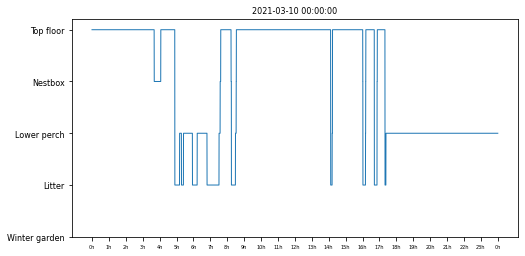

 15%|████████████▏                                                                    | 24/159 [00:58<05:39,  2.51s/it]

------------------------------------------------------------------------- hen_137


,Total_number_zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone
11502,5.0,53.0,24.0,9.0,12.0


,vertical_travel_distance,percChaoticTransition,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
11502,132.0,24.0,4.0,46.0,54.0,21.0,11.0


,ratio_percdur_percstays_2_Zone,ratio_percdur_percstays_3_Zone,ratio_percdur_percstays_4_Zone,ratio_percdur_percstays_5_Zone
11502,1.566957,0.604444,0.582857,1.483636


,latency_2_Zone_h,latency_3_Zone_h,latency_4_Zone_h,latency_5_Zone_h,latency_since15mnnestbox_h
11502,14.866667,14.896111,15.0,14.568611,14.033889


,distribution_entropy,Max_duration_zones,night_Max_duration_zones,is_mvt_night
11502,1.71816,5_Zone,4_Zone,0.0


,activity_5percentile_h,activity_50percentile_h,activity_95percentile_h,empproba_2_Zone,empproba_3_Zone,empproba_4_Zone
11502,2.178333,11.175556,16.331667,91.304348,23.636364,45.833333


,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open
11502,False,0.036389,1.807692


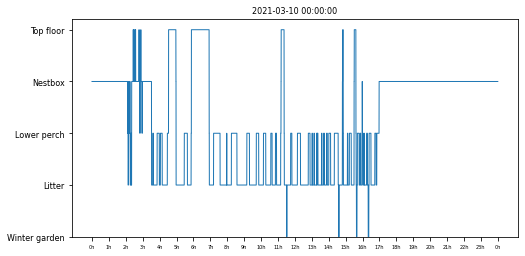

 16%|████████████▋                                                                    | 25/159 [01:00<05:36,  2.51s/it]

------------------------------------------------------------------------- hen_138


,Total_number_zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone
533,5.0,53.0,34.0,4.0,1.0


,vertical_travel_distance,percChaoticTransition,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
533,72.0,11.0,5.0,37.0,35.0,4.0,2.0


,ratio_percdur_percstays_2_Zone,ratio_percdur_percstays_3_Zone,ratio_percdur_percstays_4_Zone,ratio_percdur_percstays_5_Zone
533,1.188919,0.806286,0.83,0.415


,latency_2_Zone_h,latency_3_Zone_h,latency_4_Zone_h,latency_5_Zone_h,latency_since15mnnestbox_h
533,14.860833,14.889722,14.890833,15.0,12.440556


,distribution_entropy,Max_duration_zones,night_Max_duration_zones,is_mvt_night
533,1.566626,2_Zone,5_Zone,0.0


,activity_5percentile_h,activity_50percentile_h,activity_95percentile_h,empproba_2_Zone,empproba_3_Zone,empproba_4_Zone
533,2.292778,10.811111,16.5275,86.486486,8.571429,25.0


,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open
533,True,0.363889,17.538462


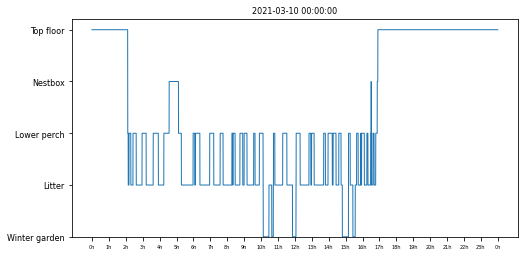

 16%|█████████████▏                                                                   | 26/159 [01:03<05:35,  2.52s/it]

------------------------------------------------------------------------- hen_139


,Total_number_zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone
805,5.0,18.0,3.0,5.0,72.0


,vertical_travel_distance,percChaoticTransition,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
805,62.0,7.0,2.0,13.0,13.0,5.0,11.0


,ratio_percdur_percstays_2_Zone,ratio_percdur_percstays_3_Zone,ratio_percdur_percstays_4_Zone,ratio_percdur_percstays_5_Zone
805,0.609231,0.101538,0.44,2.88


,latency_2_Zone_h,latency_3_Zone_h,latency_4_Zone_h,latency_5_Zone_h,latency_since15mnnestbox_h
805,14.8975,14.644722,12.846944,15.0,12.846944


,distribution_entropy,Max_duration_zones,night_Max_duration_zones,is_mvt_night
805,1.27246,5_Zone,5_Zone,0.0


,activity_5percentile_h,activity_50percentile_h,activity_95percentile_h,empproba_2_Zone,empproba_3_Zone,empproba_4_Zone
805,2.363611,14.706944,16.605556,84.615385,47.619048,50.0


,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open
805,False,0.139722,3.418803


 16%|█████████████▏                                                                   | 26/159 [01:04<05:31,  2.49s/it]


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001D07BC4E820> (for post_execute):


KeyboardInterrupt: 

In [12]:
START_TIME = time.perf_counter()
#choose specific dates to plot, November is better as hens starts to move more and the algo have never seen it
d = dt.datetime(2021,3,10)
#keep previous day info to knw where the animal was previously
df_ = df_init[(df_init['date']==d)|(df_init['date']==d-dt.timedelta(hours=24))].copy()
print(df_.shape)
#only print the hens with at least one transition per day (simplicity and interestignly)
#to sort the yaxis
dico_zone_order = {'1_Zone':0, '2_Zone':1, '3_Zone':2, '4_Zone':3, '5_Zone':4}
for henID, df_plt in tqdm.tqdm(df_.groupby(['HenID'])):
    df_info = df_daily[(df_daily['HenID']==henID)&(df_daily['level']==d)]
    if df_info.shape[0]==1:
        try:
            print('------------------------------------------------------------------------- '+henID)
            for li_m in li_mvt_2verify:
                display(df_info[li_m])
            df_plt = df_plt.sort_values(['Timestamp']).copy()
            Daterange = pd.date_range(start=d-dt.timedelta(hours=10), end=d+dt.timedelta(hours=24),freq = 'S') 
            df_plt.set_index('Timestamp', inplace=True)
            df_plt_ = df_plt.reindex(Daterange, method='ffill').reset_index()
            df_plt_.rename(columns={'index':'Timestamp'}, inplace=True)
            #add date again, as the reindexing also extended the date
            df_plt_['date'] = df_plt_['Timestamp'].map(lambda x: dt.datetime.date(x))
            #put xlabel into numbers for the ploting
            df_plt_['Zone'] = df_plt_['Zone'].map(lambda x: int(dico_zone_order[x]))    
            #keep only the date
            df_plt_ = df_plt_[df_plt_['date']==dt.datetime.date(d)]
            #plot
            plt.figure(figsize=(8,4))
            plt.yticks([0,1,2,3,4], ['Winter garden', 'Litter', 'Lower perch','Nestbox','Top floor'])
            plt.title(str(d).split('T')[0], size=8)
            plt.plot(df_plt_['Timestamp'].tolist(), df_plt_['Zone'].tolist(), linewidth=1)
            li_hour = pd.date_range(start = d,  end = d+dt.timedelta(days=1), freq = 'H')
            plt.xticks(li_hour , [str(i.hour)+'h' for i in li_hour], fontsize=5)                
            plt.yticks(fontsize=8)
            plt.ylim(0, 4.2)  
            plt.show()
            plt.clf()
            plt.close("all")    
        except Exception as e:
            print(e)
            pass
END_TIME = time.perf_counter()
print ("Total running time: %.2f mn" %((END_TIME-START_TIME)/60))

In [ ]:
df_daily.filter(li_2keep).to_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables_verified.csv'),sep=';',index=False)

In [ ]:
df_daily.filter(li_2keep)['level']

In [ ]:
#final selected variables (for now)
li_h = ['CLASS','TagID','FocalLegringName','R-Pen','InitialStartDate', 'Treatment','level','DIB','WIB','DOA','WOA',
        'verification_daily_total_duration']
li_mvt = ['perc_duration_2_Zone','perc_duration_3_Zone','perc_duration_4_Zone','perc_duration_5_Zone', #for first two months
        'duration_1_Zone','duration_2_Zone','duration_3_Zone','duration_4_Zone','duration_5_Zone', #for all, easier to analyse
        'nbr_stays_1_Zone', 'nbr_stays_2_Zone','nbr_stays_3_Zone','nbr_stays_4_Zone','nbr_stays_5_Zone',
        'ratio_percdur_percstays_2_Zone','ratio_percdur_percstays_3_Zone','ratio_percdur_percstays_4_Zone','ratio_percdur_percstays_5_Zone',
        'latency_2_Zone_h','latency_3_Zone_h','latency_4_Zone_h','latency_5_Zone_h',
        'Total_number_transition','nbr_stays_total','distribution_entropy','Total_number_zone','Max_duration_zones',
        'vertical_travel_distance','activity_50percentile_h','percChaoticTransition','SampleEntropy',
        'night_Max_duration_zones','is_mvt_night', #not more as flickering: more attention
        'in_WG_15mnAfterOpening', 'Max_duration_WG', 'latency_1_Zone_h', 'perc_1_Zone_while_WG_open']
li_2keep = li_h + li_mvt

In [ ]:
df_daily[(df_daily['HenID']=='hen_52')&(df_daily['Total_number_transition']==0)]